## Multi-label classification

In [1]:
%pdb off
%matplotlib inline
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import math

Automatic pdb calling has been turned OFF


In [2]:
PATH = './'   # Our data are in this same directory

In [3]:
# Data preparation steps if you are using Crestle:

# Already did this, uncomment if you (Alex) need to repeat /redo it
os.makedirs(PATH+"models", exist_ok=True)
os.makedirs(PATH+'tmp', exist_ok=True)

# !ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train-jpg {PATH}
# !ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train_v2.csv {PATH}
# !ln -s /cache/planet/tmp {PATH}

###### Read the CSV file containing the whaleIDs into a new dataframe

In [4]:
whale_ids=pd.read_csv(PATH+"train.csv")

###### Now let's take a look at the whale IDS

In [5]:
whale_ids.head()

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3


In [6]:
whale_ids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9850 entries, 0 to 9849
Data columns (total 2 columns):
Image    9850 non-null object
Id       9850 non-null object
dtypes: object(2)
memory usage: 154.0+ KB


In [7]:
num_photos_of_each_whale=whale_ids.pivot_table(index='Id', aggfunc=len)
num_photos_of_each_whale.rename(columns={'Image': "num_images"}, inplace=True)
num_photos_of_each_whale=num_photos_of_each_whale.sort_values('num_images', axis=0,ascending=False)
num_photos_of_each_whale.describe()

,num_images
count,4251.000000
mean,2.317102
std,12.586066
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,810.000000


In [8]:
# How many whales do we only have one photo of?
(num_photos_of_each_whale['num_images'] == 1).sum()

2220

In [9]:
# And how many How many whales do we only have one photo of?
(num_photos_of_each_whale['num_images'] == 2).sum()

1034

In [10]:
# What does our distribution of photos look like (whales with )
whales_with_n_photos=num_photos_of_each_whale.reset_index().pivot_table(index='num_images', aggfunc=len)
whales_with_n_photos.index.set_names("has_n_images", inplace=True)
whales_with_n_photos.rename(columns={'Id': "num_whales"}, inplace=True)
whales_with_n_photos

,num_whales
has_n_images,
1,2220
2,1034
3,492
4,192
5,102
6,61
7,40
8,23
9,21


In [11]:
#whales_with_n_photos['num_whales'].iloc[2:26].sum()
whales_with_n_photos['num_whales'].sum()

4251

So, what do we know so far?
- 4251 unique whales, assuming every "new whale" is unique"
- 3441 Known, identified whales (= 4251 - 810 "new whales")
- 3254 of these have only 1 or 2 photos
- 996 whales have 3 or more photos
From this we see that most whales have only 1 or 2 photos - which the competition rules already told us.  

### Now lets look at some of the images

In [12]:
TRAINPATH=f'{PATH}train/'
files = os.listdir(TRAINPATH)[:6]
files

['00022e1a.jpg',
 '000466c4.jpg',
 '00087b01.jpg',
 '001296d5.jpg',
 '0014cfdf.jpg',
 '0025e8c2.jpg']

<p> And here we look at some of the images </p>

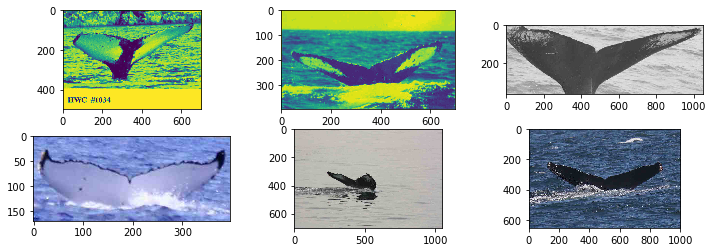

In [13]:
f, axarr = plt.subplots(2,3)
f.set_figwidth(12)
for r, filename in enumerate(files):
    img = plt.imread(f"{TRAINPATH}/{filename}")
    axarr[r%2,r%3].imshow(img)


### Splitting into train/validation sets

#### We are going to train/test on the whales for which we have more than 4 images.  Lets get a list of them.

In [14]:
known_whales = whale_ids[whale_ids['Id'] != "new_whale"]
known_whales.info()
# value_counts=known_whales['Id'].value_counts()
# to_use=value_counts[value_counts >= 4].index.
# known_whales_with_4_images = known_whales.set_index('Id')
# known_whales_with_4_images.loc[to_use.values]
# known_whales_with_4_images.reset_index(inplace=True)
# known_whales_with_4_images

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9040 entries, 0 to 9849
Data columns (total 2 columns):
Image    9040 non-null object
Id       9040 non-null object
dtypes: object(2)
memory usage: 211.9+ KB


In [15]:
whales_with_more_than_3_photos = known_whales.pivot_table(index="Id", aggfunc=lambda l:None if len(l) <= 3 else list(l))
whales_with_more_than_3_photos.dropna(inplace=True)
whales_with_more_than_3_photos.head()

,Image
Id,
w_02d5fad,"[16a5c1e6.jpg, 1c789413.jpg, 86a50202.jpg, 948..."
w_02facde,"[2f0d7fae.jpg, 325b96a4.jpg, 3358544d.jpg, 4b6..."
w_03c84ef,"[34470ebb.jpg, 6a2c31d4.jpg, a14f7c43.jpg, f70..."
w_0408054,"[bc9a50f2.jpg, c800410d.jpg, cab0ff28.jpg, d13..."
w_045d9fc,"[29c82382.jpg, 562d7297.jpg, 60c3e75f.jpg, 65d..."


######  That gives us 504 whales to train on.  We'll split the first image off as our validation image, and train on the rest.

In [16]:
train_test_list = []
for index, row in whales_with_more_than_3_photos.reset_index().iterrows():
    train_test_list.append([row['Id'], row['Image'][0], row['Image'][1:]])

train_test_matrix = pd.DataFrame(train_test_list, columns=["Id", "Test_Img", "Train_Img"])
train_test_matrix.head()

,Id,Test_Img,Train_Img
0,w_02d5fad,16a5c1e6.jpg,"[1c789413.jpg, 86a50202.jpg, 948dba9e.jpg, a4f..."
1,w_02facde,2f0d7fae.jpg,"[325b96a4.jpg, 3358544d.jpg, 4b6a4b19.jpg, 694..."
2,w_03c84ef,34470ebb.jpg,"[6a2c31d4.jpg, a14f7c43.jpg, f702325b.jpg]"
3,w_0408054,bc9a50f2.jpg,"[c800410d.jpg, cab0ff28.jpg, d1305334.jpg]"
4,w_045d9fc,29c82382.jpg,"[562d7297.jpg, 60c3e75f.jpg, 65dd4491.jpg, 8a9..."


Whale ID: w_02d5fad, photo #0
Whale ID: w_02d5fad, photo #1
Whale ID: w_02d5fad, photo #2
Whale ID: w_02d5fad, photo #3
Whale ID: w_02facde, photo #0
Whale ID: w_02facde, photo #1
Whale ID: w_02facde, photo #2
Whale ID: w_02facde, photo #3
Whale ID: w_02facde, photo #4
Whale ID: w_02facde, photo #5
Whale ID: w_02facde, photo #6


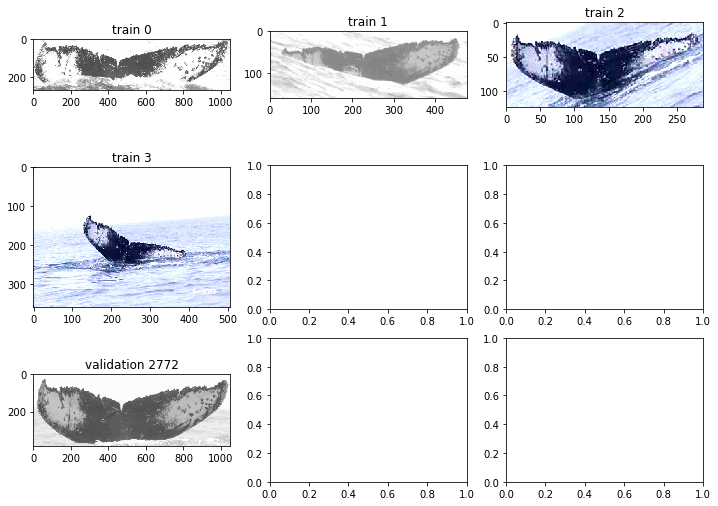

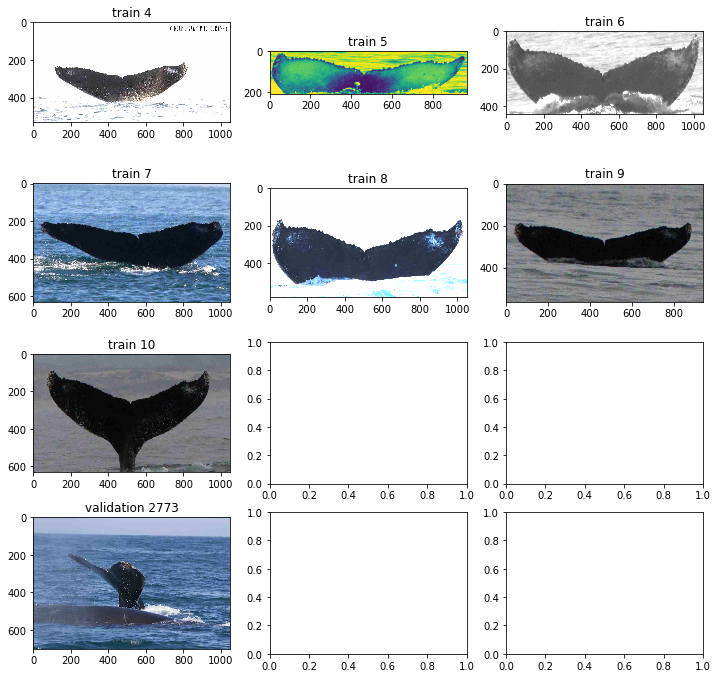

In [170]:
# Turn it back into a dataframe that we can usee to write out the csv data from
result_list = []
for index, row in train_test_matrix.iterrows():
    whale_id = row[0]
    whale_photos = row[2]
    for img in whale_photos:
        result_list.append([img, whale_id])

train_images = pd.DataFrame(result_list, columns=["Test_Img", "Id"])
num_train_images = len(train_images)
validation_images = train_test_matrix[["Test_Img", "Id"]]
num_val_images = len(validation_images)
train_val_images = pd.concat([train_images, validation_images])
len(train_val_images)
num_train_images + num_val_images
def print_whale(whale_id, train_val_from_file):
    wdf = train_val_from_file[train_val_from_file['Id'] == whale_id]
    wdf_training = wdf.iloc[0:-1]
    wdf_validation = wdf.iloc[-1]
    # Display images in a matplotlib subplots
    nimages = len(wdf)-1
    cols = 3
    rows = math.ceil(nimages/cols) + 1
    f, axes = plt.subplots(rows, cols)
    f.set_figwidth(12)
    f.set_figheight(3*rows)
    for i, (file_idx,file,ident) in enumerate(wdf_training.itertuples()):
        print(f"Whale ID: {ident}, photo #{i}")
        fn=f"{TRAINPATH}{file}"
        img = plt.imread(fn)
        img=max_and_scale_array(img, 200)
        axes[int(i/cols)][i%cols].imshow(img)
        axes[int(i/cols)][i%cols].set_title("train "+str(file_idx))

    fn=wdf_validation.iloc[0]
    fn=f"{TRAINPATH}{fn}"
    img = plt.imread(fn)
    axes[rows-1][0].imshow(img)
    axes[rows-1][0].set_title("validation " + str(wdf_validation.name) )

# Read in the train images and see if they match our indexes
train_val_from_file = pd.read_csv(PATH+"cnn_train_val_images.csv")
unique_whale_ids = train_val_from_file['Id'].unique()[:2]
for whale_id in unique_whale_ids:
    print_whale(whale_id, train_val_from_file)
train_val_images.to_csv(PATH+"cnn_train_val_images.csv", index=False)

In [31]:
whale_id = "w_02d5fad"
wdf = train_val_from_file[train_val_from_file['Id'] == whale_id]
wdf.iloc[-1].name

2772

In [159]:
def max_and_scale_array(a, max, scale_max=None):
    # img is an array of unsigned bytes of arbitrary shape.
    # Truncate all values so that all values are below max
    # Then rescale all values in img to by a factor of "scale"
    if scale_max == None: scale_max = np.iinfo(a.dtype).max
    assert type(a) == np.ndarray, f"a must be of type np.ndarray, was passed {type(a)}"
    assert max <= np.iinfo(a.dtype).max, f"max must be less than the max possible value for type {a.dtype}"
    assert scale_max <= np.iinfo(a.dtype).max, f"scale_max must be less than the max possible value for type {a.dtype}"

    max_array = np.ones(a.shape)
    max_array = max_array * max
    a_truncated = np.minimum(a, max_array)
    return (a_truncated * (scale_max/max)).astype(a.dtype)

max_and_scale_array(np.array([230,120,11]).astype(np.ubyte), 200)
    

array([254, 153,  14], dtype=uint8)

In [147]:
    assert 256 <= 

In [148]:
np.iinfo(np.array([230,120,11]).dtype).max

2147483647

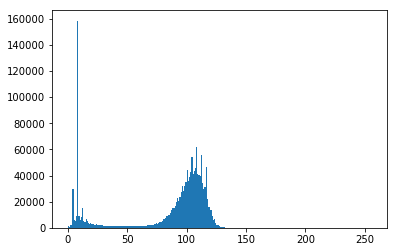

In [155]:
_ = plt.hist(imgdata.flatten(), bins=256, range=(0.0, 256))

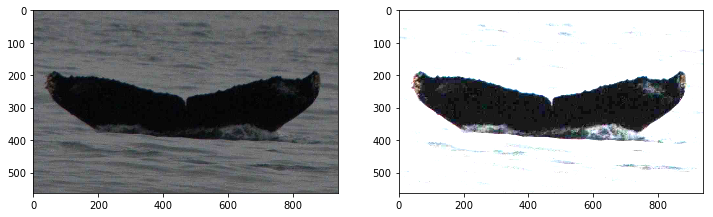

In [164]:
from PIL import Image
imgdata = plt.imread(f"{TRAINPATH}a2789a7b.jpg")
#imgdata = imgdata*1.00001
f, (plt1, plt2) = plt.subplots(1,2)
f.set_figwidth(12)
imgdata = imgdata.astype(np.ubyte)
plt1.imshow(imgdata)
# #imgcrop=imgdata[200:400,400:600]
# #supertight=imgdata[300:302,500:502]

# img_brightened = (imgdata*3)
plt2.imshow(max_and_scale_array(imgdata, 80))
# img_brightened.dtype
# np.dtype
#_ = plt.hist(imgdata.flatten(), bins=256, range=(0.0, 256))


In [57]:
a=np.array([[[1,2,3],[4,5,6],[7,8,9]]])
print(a*2)
imgdata[:3,:3,:3]*1.1

[[[ 2  4  6]
  [ 8 10 12]
  [14 16 18]]]


array([[[ 130.68,  130.68,  130.68],
        [ 130.68,  130.68,  130.68],
        [ 130.68,  130.68,  130.68]],

       [[ 130.68,  130.68,  130.68],
        [ 130.68,  130.68,  130.68],
        [ 130.68,  130.68,  130.68]],

       [[ 130.68,  130.68,  130.68],
        [ 130.68,  130.68,  130.68],
        [ 130.68,  130.68,  130.68]]])

In [48]:
imgdata[0,0,0]


array([[[ 108.0108,  108.0108,  108.0108],
        [ 108.0108,  108.0108,  108.0108],
        [ 108.0108,  108.0108,  108.0108],
        ..., 
        [  95.0095,   94.0094,  102.0102],
        [  95.0095,   94.0094,  102.0102],
        [  95.0095,   94.0094,  102.0102]],

       [[ 108.0108,  108.0108,  108.0108],
        [ 108.0108,  108.0108,  108.0108],
        [ 108.0108,  108.0108,  108.0108],
        ..., 
        [  98.0098,   97.0097,  105.0105],
        [  98.0098,   97.0097,  105.0105],
        [  98.0098,   97.0097,  105.0105]],

       [[ 108.0108,  108.0108,  108.0108],
        [ 108.0108,  108.0108,  108.0108],
        [ 108.0108,  108.0108,  108.0108],
        ..., 
        [ 102.0102,  101.0101,  109.0109],
        [ 102.0102,  101.0101,  109.0109],
        [ 102.0102,  101.0101,  109.0109]],

       ..., 
       [[ 111.0111,  111.0111,  111.0111],
        [ 109.0109,  109.0109,  109.0109],
        [ 107.0107,  107.0107,  107.0107],
        ..., 
        [  86.0086,   

## Multi-label models for Planet dataset

In [22]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [23]:
model = resnet34
sz = 224

In [24]:
# make a list of the training indexes and the validation indices
label_csv = f'{PATH}cnn_train_val_images.csv'
val_idxs = range(num_train_images, num_train_images+num_val_images)

In [25]:
def get_data(sz):
    tfms = tfms_from_model(model, sz, aug_tfms=transforms_side_on, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train', label_csv, tfms=tfms,
                    val_idxs=val_idxs, test_name='test')

In [26]:
data = get_data(256)

In [27]:
x,y = next(iter(data.val_dl))

In [ ]:
y

In [ ]:
list(zip(data.classes, y))

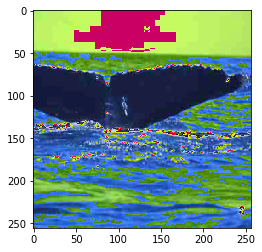

In [28]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

In [29]:
sz=64

In [30]:
data = get_data(sz)

In [31]:
data = data.resize(int(sz*1.3), 'tmp')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [34]:
from planet import f2
metrics=[f2]
#learn = ConvLearner.pretrained(model, data, metrics=metrics)

learn = ConvLearner.pretrained(model, data, precompute=True)
lrf=learn.lr_find()

100%|██████████| 244/244 [06:46<00:00,  1.66s/it]


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      7.227083   119.750504 0.003906  



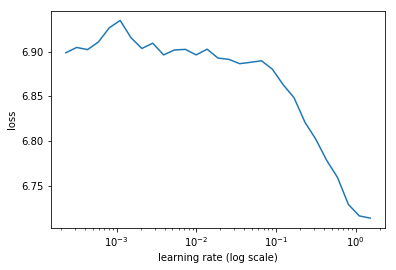

In [35]:
learn.sched.plot()

In [37]:
learn.save("256_save_3-7-2018")

In [36]:
lr = 0.3

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
lrs = np.array([lr/9,lr/3,lr])

In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.save(f'{sz}')

In [ ]:
learn.sched.plot_loss()

In [ ]:
sz=128

In [ ]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

In [ ]:
sz=256

In [ ]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

In [ ]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

In [ ]:
f2(preds,y)

### End